## Week 5 Class activities
This notebook is a starting point for the exercises and activities that we'll do in class.

Before you attempt any of these activities, make sure to watch the video lectures for this week.

### Using git
Let's start with some practice using git. 

I set up a class repository. You should all have full access.

Enter GitHub Desktop, go to File > Clone Repository. Then clone `UCLALuskinDataScience/git-practice` to somewhere on your computer.

Try adding a new file first. Create a text file on your computer and save it in the `git-practice` folder. Go to GitHub Desktop. You should see your new file.
* Add a commit message
* Click on "commit to main"
* Fetch the origin (in case anyone has updated the repository in the meantime)
* Click on "push origin"

You should now see your file in the [cloud repository](https://github.com/UCLALuskinDataScience/git-practice).

Fetch the origin again. Now try editing your neighbor's file, or the code that's in there already. Commit, and push it back to the cloud. 

What happens if you both try and edit it at once?

### ADUs and neighborhood-level predictors
Let's continue with the example of ADUs from the video lecture.

We'll add a broader set of predictors at the neighborhood (census tract) level, and see if that improves our predictive performance.

First, let's load in the DataFrame that we saved during the lecture. If you ran the code for the lecture (Part 1 - Data preparation), you should be able to load it in as follows.

In [1]:
import pandas as pd
import geopandas as gpd


parcels = pd.read_pickle('../Lectures/joined_permits.pandas')

# convert to a geodataframe. Same code as from video lecture
parcels = gpd.GeoDataFrame(parcels, 
                    geometry = gpd.points_from_xy(
                        parcels.CENTER_LON, 
                        parcels.CENTER_LAT, crs='EPSG:4326'))

# check it looks OK
parcels.head()

,APN,UseType,UseDescription,YearBuilt1,Units1,Bedrooms1,Bathrooms1,SQFTmain1,Roll_LandValue,Roll_ImpValue,Roll_LandBaseYear,Roll_ImpBaseYear,CENTER_LAT,CENTER_LON,Assessor Book,Assessor Page,Assessor Parcel,# of Accessory Dwelling Units,hasADU,geometry
0,2004-001-003,Residential,Single,1973.0,1.0,4.0,3.0,2090.0,543000.0,231000.0,2006,2006,34.220220,-118.620669,2340.0,20.0,013,1.0,True,POINT (-118.62067 34.22022)
1,2004-001-004,Residential,Single,1973.0,1.0,5.0,3.0,2479.0,345587.0,238650.0,2010,2010,34.220039,-118.620668,5535.0,34.0,001,1.0,True,POINT (-118.62067 34.22004)
2,2004-001-005,Residential,Single,1973.0,1.0,4.0,2.0,2057.0,490917.0,185207.0,2018,2018,34.219858,-118.620676,2639.0,23.0,005,1.0,True,POINT (-118.62068 34.21986)
3,2004-001-008,Residential,Single,1978.0,1.0,4.0,3.0,2423.0,119775.0,207020.0,1980,1980,34.220334,-118.622706,2276.0,18.0,028,1.0,True,POINT (-118.62271 34.22033)
4,2004-001-009,Residential,Single,1978.0,1.0,4.0,3.0,2226.0,130511.0,195871.0,1984,1984,34.220323,-118.623050,4249.0,6.0,016,1.0,True,POINT (-118.62305 34.22032)


Now let's load in our tract-level data from EnviroScreen. Again, this is the same code as we've used before.

In [2]:
enviroscreen = gpd.read_file('../Lectures/data/CalEnviroScreen/CES4 Final Shapefile.shp')

Now we can add the tract-level attributes to each parcel. (Important: we want to keep the dataset at the parcel level, rather than grouping by tract and getting counts as we did before.)

<div class="alert alert-block alert-info">
    <strong>Exercise:</strong> Do a spatial join to add the EnviroScreen attributes for the relevant census tract to each parcel.
</div>

In [3]:
# your code here

gdf = gpd.sjoin(parcels, enviroscreen.to_crs('EPSG:4326'), how='left', predicate='intersects')

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Estimate a random forests model that takes advantage of the new columns you just joined. Create a new variable, <strong>y_pred</strong> with your predicted values.

*Hints:*
- You'll first need to choose which variables you want. Focus on the numeric variables for now - don't worry about creating dummies from the string variables
- Then split your dataset into training and testing portions
- Then estimate your model
- Then make your predictions on the testing dataset

In [4]:
# your code here
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# choose which variables to use
# this is a shortcut to get all
# you could have specified a list manually
xvars = enviroscreen.dtypes[(enviroscreen.dtypes=='float64') | (enviroscreen.dtypes=='int64')].index.tolist()

# drop some that are identifiers, and add the ones from the parcels dataset
xvars.remove('Tract')
xvars.remove('ZIP')
xvars += ['YearBuilt1', 'Units1', 'Bedrooms1',
       'Bathrooms1', 'SQFTmain1', 'Roll_LandValue', 'Roll_ImpValue',
       'Roll_LandBaseYear', 'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON']
yvar = 'hasADU'

# create a dataframe with no NaNs
df_to_fit = gdf[xvars+[yvar]].dropna()


# train test split
X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

# make predictions
y_pred = rf.predict(X_test)



<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Plot a confusion matrix, plus any other measures of fit that you think would be useful.

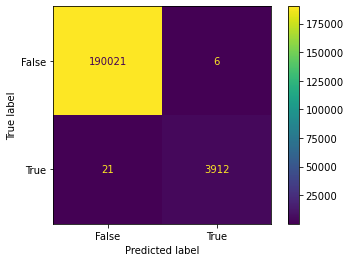

In [5]:
# your code here
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Which variables are most important to your predictions?

In [ ]:
# code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

# plot
fig, ax = plt.subplots(figsize=(4,15))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

<div class="alert alert-block alert-info">
    <strong>Exercise:</strong> The model that I estimated was pretty counterintuitive in terms of the feature importances. (Maybe you got different results.) Think about how to explain your findings, and what you might do to investigate further?
</div>

Add some of your thoughts here.

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Use a neural net to estimate the probability of adding an ADU. How do your predictions compare to the random forests?
</div>

*Hint*: Remember to standardize your variables first. Since you don't have any binary (dummy) variables, you can standardize all of your x variables.

In [ ]:
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier

# your code here

# scale the columns
scaler = preprocessing.StandardScaler().fit(df_to_fit[xvars])
df_scaled = pd.DataFrame(scaler.transform(df_to_fit[xvars]), 
                         columns=xvars, index=df_to_fit.index)

# create a DataFrame with these scaled columns joined to the columns that we didn't scale
df_scaled = df_scaled.join(df_to_fit[yvar])

# standardize
X_train, X_test, y_train, y_test = train_test_split(
      df_scaled[xvars], df_scaled[yvar], test_size = 0.25, random_state = 1)

# estimate the neural net
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

# predictions
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Experiment with some of the hyperparameters (e.g. layer sizes). How do these affect your results?
</div>

In [ ]:
# your code here

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Map your predictions. You could create a census-tract level variable with the predicted probability of a parcel having an ADU. You could also map the predicted vs actual ADU numbers.</div>

<div class="alert alert-block alert-info">
<h3>What you should have learned</h3>
<ul>
  <li>Gain more practice with spatial joins</li>
  <li>Understand how to estimate a random forests model.</li>
  <li>Understand how to interpret the results of machine learning classification models.</li>
</ul>
</div>